In [39]:
%matplotlib inline

In [ ]:
import sklearn
import nose
import astroML_addons
import astroML
import scipy
import pandas
import xdgmm
from astropy.io import fits
import csv
import os
from shutil import copyfile
import numpy as np
import matplotlib.pyplot as plt

#from demo_plots import *

import requests
import ast

import warnings
warnings.filterwarnings('ignore')

def fetchFirstVals():
    
    deltaW = []
    sigW = []
    w1 = []
    w2 = []
    w1s = []
    w2s = []
    mjd = []
    

    directorystr = './galaxy_csvfiles-150318/'
    directory = os.fsencode(directorystr)
    filelist = os.listdir(directory)
    #print(len(filelist))
    readdata = np.zeros((22,len(filelist))) #one big list to rule them all
    fileCount = 0 #to keep our place in each list as we go through the files
    for file in filelist:
        filestr = os.fsdecode(file)
        if(filestr.endswith(".csv")):
            readfile = open('./galaxy_csvfiles-150318/'+filestr, 'r')
            reader = csv.reader(readfile)
            typeIndex = 0 #to iterate through the w1, w2, etc list
            for row in enumerate(reader):
                #print(row[1][1])
                try:
                    readdata[typeIndex][fileCount] = row[1][1]
                except ValueError:
                    continue
                except IndexError:
                    continue
                #print(readdata[typeIndex])
                typeIndex = typeIndex + 1
            fileCount = fileCount + 1
                    
    w1 = [float(x) for x in readdata[7]]
    w2 = [float(x) for x in readdata[9]]
    w1s = [float(x) for x in readdata[11]]
    w2s = [float(x) for x in readdata[13]]
    
    deltaW = [x - y for x,y in zip(w1,w2)]
    sigW = [np.sqrt(sx**2 + sy**2) for sx,sy in zip(w1s, w2s)]
    
    return deltaW, sigW, len(filelist)

result = fetchFirstVals()
deltaW = result[0]
sigW = result[1]
npoints = result[2]

xdgmm = xdgmm.XDGMM()

param_range = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
deltaW = np.array(deltaW)

deltaW = deltaW.reshape(deltaW.shape[0], 1)
print(deltaW.shape)
sigW = np.array(sigW)

sigW = sigW.reshape(sigW.shape[0], 1,1)
print(sigW.shape)

bic, optimal_n_comp, lowest_bic = xdgmm.bic_test(deltaW, sigW, param_range)

print('yes')


(47524, 1)
(47524, 1, 1)
N = 1 , BIC = 280772.929868
N = 2 , BIC = 213269.478602


In [41]:
xdgmm.n_components = 5
xdgmm = xdgmm.fit(deltaW, sigW)
print('done')

xdgmm.save_model('notNullTrialset.fit')

done


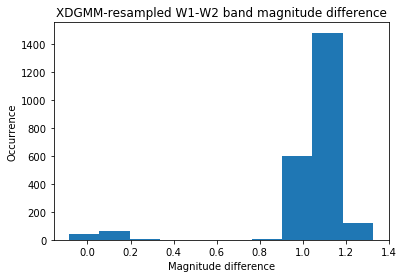

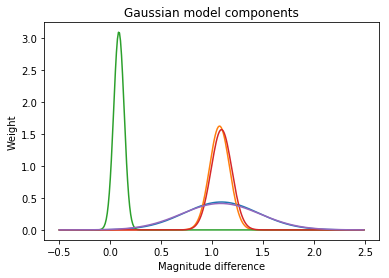

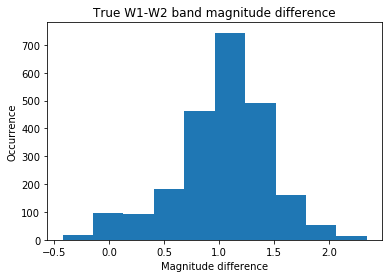

In [81]:
def plot_sample(x_true, y_true, x, y, sample, xdgmm):
    setup_text_plots(fontsize=16, usetex=True)
    plt.clf()
    fig = plt.figure(figsize=(12, 9))
    fig.subplots_adjust(left=0.1, right=0.95,
                        bottom=0.1, top=0.95,
                        wspace=0.02, hspace=0.02)

    ax1 = fig.add_subplot(221)
    ax1.scatter(x_true, y_true, s=4, lw=0, c='k')

    ax2 = fig.add_subplot(222)

    ax2.scatter(x, y, s=4, lw=0, c='k')

    ax3 = fig.add_subplot(223)
    ax3.scatter(sample[:, 0], sample[:, 1], s=4, lw=0, c='k')

    ax4 = fig.add_subplot(224)
    for i in range(xdgmm.n_components):
        draw_ellipse(xdgmm.mu[i], xdgmm.V[i], scales=[2], ax=ax4,
                     ec='k', fc='gray', alpha=0.2)

    titles = ["True Distribution", "Noisy Distribution",
              "Extreme Deconvolution\n  resampling",
            "Extreme Deconvolution\n  cluster locations"]

    ax = [ax1, ax2, ax3, ax4]

    for i in range(4):
        ax[i].set_xlim(-1, 13)
        ax[i].set_ylim(-6, 16)

        ax[i].xaxis.set_major_locator(plt.MultipleLocator(4))
        ax[i].yaxis.set_major_locator(plt.MultipleLocator(5))

        ax[i].text(0.05, 0.95, titles[i],
                   ha='left', va='top', transform=ax[i].transAxes)

        if i in (0, 1):
            ax[i].xaxis.set_major_formatter(plt.NullFormatter())
        else:
            ax[i].set_xlabel('$x$', fontsize = 18)

        if i in (1, 3):
            ax[i].yaxis.set_major_formatter(plt.NullFormatter())
        else:
            ax[i].set_ylabel('$y$', fontsize = 18)

    plt.show()
    
def makeGaussian(x, mu, sig):
    #return (1.0/(alpha*2.0*np.sqrt(np.pi)))*np.exp((-0.5*(x-mu)/alpha)**2)
    return (np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))/(2.0*np.pi*sig)
#xdgmm.read_model('notNullTrialset.fit')

#xdgmm2= xdgmm.XDGMM(filename='notNullTrialset.fit')



sample = xdgmm.sample(npoints)
plt.figure()
h1 = plt.hist(sample)
plt.title('XDGMM-resampled W1-W2 band magnitude difference')
plt.xlabel('Magnitude difference')
plt.ylabel('Occurrence')



plt.figure()

#for mu, alpha in xdgmm.mu, xdgmm.weights:
x = np.arange(-0.5, 2.5, 0.01)
plt.plot(x, makeGaussian(x, xdgmm.mu[0], xdgmm.weights[0]))
plt.plot(x, makeGaussian(x, xdgmm.mu[1], xdgmm.weights[1]))
plt.plot(x, makeGaussian(x, xdgmm.mu[2], xdgmm.weights[2]))
plt.plot(x, makeGaussian(x, xdgmm.mu[3], xdgmm.weights[3]))
plt.plot(x, makeGaussian(x, xdgmm.mu[4], xdgmm.weights[4]))
plt.title('Gaussian model components')
plt.xlabel('Magnitude difference')
plt.ylabel('Weight')

plt.figure()
plt.hist(deltaW)
plt.title('True W1-W2 band magnitude difference')
plt.xlabel('Magnitude difference')
plt.ylabel('Occurrence')


In [82]:

tryProp = xdgmm.score_samples(1.5, 0.03)

TypeError: 'float' object is not subscriptable